In [1]:
!pip install torchview

In [2]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
from torchvision import models
import torch.utils.data
import torch.nn
import torch.nn.functional as functional
import numpy as np
import time
import os
import graphviz
from torchview import draw_graph
from matplotlib import pyplot as plt


libgomp: Invalid value for environment variable OMP_NUM_THREADS
/home/user/conda/envs/dl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/user/conda/envs/dl/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_hip.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## **1. Загрузка данных**

In [3]:
dir_name = os.getcwd()
def download_datasets(transform):
  train_dataset = torchvision.datasets.CIFAR10(
      root = dir_name, train = True, download = True,
      transform = transform
  )
  test_dataset = torchvision.datasets.CIFAR10(
      root = dir_name, train = False, download = True,
      transform = transform
  )
  return train_dataset, test_dataset

## **2. Архитектура сети**

In [4]:
learning_rate = 0.001
num_epochs = 5
batch_size = 512

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_function = torch.nn.CrossEntropyLoss()

In [5]:
def get_loaders(train_dataset, test_dataset):
  train_data_loader = torch.utils.data.DataLoader(
      train_dataset, batch_size = batch_size, shuffle = True, num_workers=4, pin_memory=True,
  )
  test_data_loader = torch.utils.data.DataLoader(
      test_dataset, batch_size = batch_size, shuffle = False, num_workers=4, pin_memory=True,
  )
  return train_data_loader, test_data_loader

In [6]:
def create_model_first(class_model, weights):
  neural_network = class_model(weights = weights)

  for params in neural_network.parameters():
    params.requires_grad = False

  input_layers = neural_network.fc.in_features

  neural_network.fc = torch.nn.Linear(input_layers, 10)
  return neural_network

def create_model_second(class_model, weights):
  neural_network = class_model(weights = weights)

  for params in neural_network.parameters():
    params.requires_grad = False

  input_layers = neural_network.fc.in_features

  neural_network.fc = torch.nn.Sequential(
        torch.nn.Linear(input_layers, input_layers//2),
        torch.nn.ReLU(),
        torch.nn.Linear(input_layers//2, 10),
        )
  return neural_network

In [7]:
def visualize(model, name, input_size=(1,3,32,32)):
  print("Model: {}".format(name))
  print(model)
  model_graph = draw_graph(model, input_size=input_size, expand_nested=True)
  return model_graph.visual_graph

## **3. Обучение и тестирование**



In [8]:
def get_accuracy(model, data_loader, device):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

def get_loss(model, data_loader, device):
    loss = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            loss += loss_function(outputs, labels)
            n += labels.size(0)
    return loss / n

def accuracy(outputs, labels):
  _, predicted = torch.max(outputs.data, 1)
  return torch.tensor(torch.sum(predicted == labels).item() / len(predicted))

def epoch_acc(accuracies):
  return torch.stack(accuracies).mean()

def epoch_loss(losses):
  return torch.stack(losses).mean()

In [9]:
def train(cnn_model, data_loader, epochs, loss_function, optimizer, device):
  start_time = time.time()
  for epoch in range(epochs):
    start_epoch = time.time()
    accuracies = []
    losses = []
    for i, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = cnn_model(images)
        loss = loss_function(outputs, labels)
        acc = accuracy(outputs, labels)

        losses.append(loss)
        accuracies.append(acc)

        loss.backward()
        optimizer.step()
    total_time_epoch = time.time() - start_epoch
    print('Epoch[{}]: Loss = {:.4f}, Train accuracy = {:.4f}, Time epoch = {:.4f}'.
          format(epoch + 1,
                 epoch_loss(losses),
                 epoch_acc(accuracies),
                 total_time_epoch))
  total_time = time.time() - start_time
  print('Total time {}'.format(total_time))


def test(cnn_model, test_data_loader, device):
  loss_val = get_loss(cnn_model, test_data_loader, device)
  acc_val = get_accuracy(cnn_model, test_data_loader, device)
  print('Loss = {:.4f}, Test accuracy = {:.4f}'.format(
    loss_val,
    acc_val))
  return loss_val, acc_val

In [10]:
def train_and_test(train_dataset, test_dataset, neural_network):
  train_data_loader, test_data_loader = get_loaders(train_dataset, test_dataset)

  neural_network.to(device)

  optimizer = torch.optim.Adam(
    neural_network.fc.parameters(),
    lr = learning_rate)

  print("TRAIN:")
  train(neural_network, train_data_loader, num_epochs, loss_function, optimizer, device)

  print("TEST:")
  return test(neural_network, test_data_loader, device)

## **4. Эксперименты**


##GoogleNet

In [11]:
train_dataset_googlenet, test_dataset_googlenet = download_datasets(models.GoogLeNet_Weights.DEFAULT.transforms())

neural_network = create_model_first(models.googlenet, models.GoogLeNet_Weights.DEFAULT)

Files already downloaded and verified
Files already downloaded and verified


Model: GoogLeNet with transform last layer
GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, 

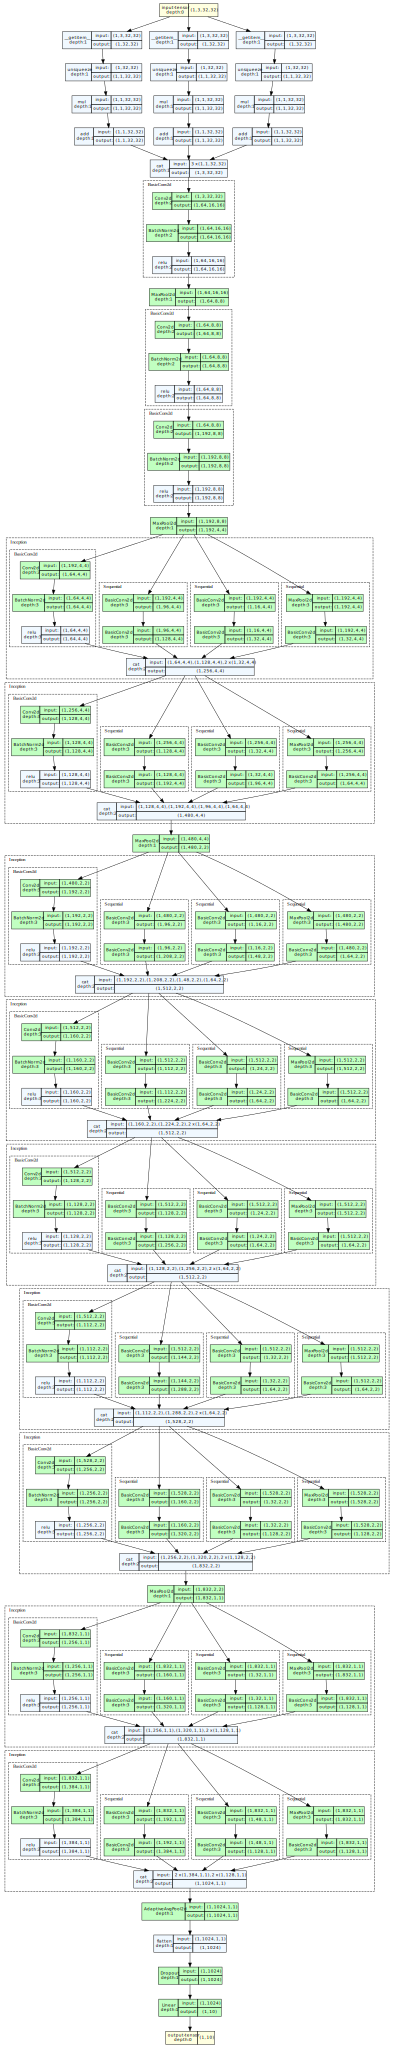

In [12]:
visualize(neural_network, "GoogLeNet with transform last layer")

In [13]:
_, gnet_first_acc = train_and_test(train_dataset_googlenet, test_dataset_googlenet, neural_network)

TRAIN:
Epoch[1]: Loss = 1.3403, Train accuracy = 0.6282, Time epoch = 31.2949
Epoch[2]: Loss = 0.8604, Train accuracy = 0.7298, Time epoch = 28.8668
Epoch[3]: Loss = 0.7728, Train accuracy = 0.7479, Time epoch = 29.4555
Epoch[4]: Loss = 0.7297, Train accuracy = 0.7582, Time epoch = 28.0589
Epoch[5]: Loss = 0.7065, Train accuracy = 0.7627, Time epoch = 28.8148
Total time 146.4949676990509
TEST:
Loss = 0.0015, Test accuracy = 0.7494


In [14]:
neural_network = create_model_second(models.googlenet, models.GoogLeNet_Weights.DEFAULT)

Model: GoogLeNet with transform two last layers
GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d

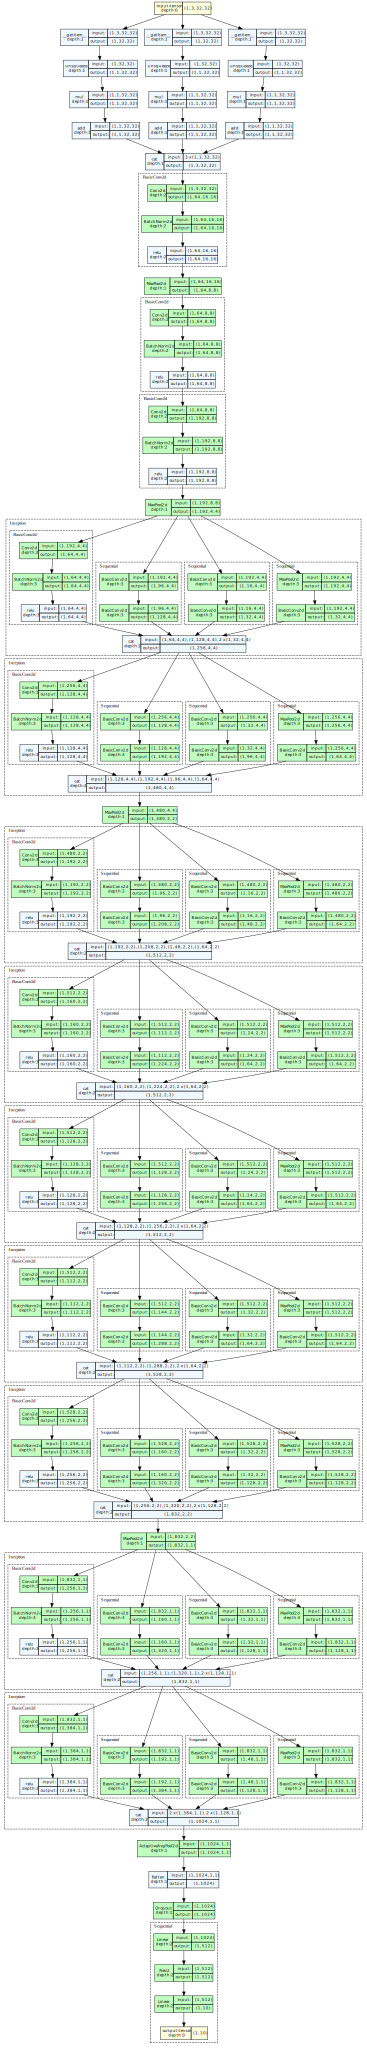

In [15]:
visualize(neural_network, "GoogLeNet with transform two last layers")

In [16]:
_, gnet_second_acc = train_and_test(train_dataset_googlenet, test_dataset_googlenet, neural_network)

TRAIN:
Epoch[1]: Loss = 0.9502, Train accuracy = 0.6910, Time epoch = 28.0818
Epoch[2]: Loss = 0.7158, Train accuracy = 0.7528, Time epoch = 28.2012
Epoch[3]: Loss = 0.6854, Train accuracy = 0.7618, Time epoch = 28.1160
Epoch[4]: Loss = 0.6686, Train accuracy = 0.7684, Time epoch = 28.2216
Epoch[5]: Loss = 0.6547, Train accuracy = 0.7724, Time epoch = 28.5264
Total time 141.1514391899109
TEST:
Loss = 0.0014, Test accuracy = 0.7532


##ResNet

In [17]:
train_dataset_resnet, test_dataset_resnet = download_datasets(models.ResNet152_Weights.IMAGENET1K_V2.DEFAULT.transforms())

Files already downloaded and verified
Files already downloaded and verified


In [18]:
neural_network = create_model_first(models.resnet152, models.ResNet152_Weights.IMAGENET1K_V2.DEFAULT)

In [19]:
visualize(neural_network, "ResNet152 with transform last layer")

Model: ResNet152 with transform last layer
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv

In [20]:
_, resnet_first_acc = train_and_test(train_dataset_resnet, test_dataset_resnet, neural_network)

TRAIN:
Epoch[1]: Loss = 1.0761, Train accuracy = 0.7069, Time epoch = 42.3166
Epoch[2]: Loss = 0.6314, Train accuracy = 0.8065, Time epoch = 42.0480
Epoch[3]: Loss = 0.5481, Train accuracy = 0.8260, Time epoch = 42.3457
Epoch[4]: Loss = 0.5046, Train accuracy = 0.8374, Time epoch = 42.1464
Epoch[5]: Loss = 0.4751, Train accuracy = 0.8468, Time epoch = 42.0624
Total time 210.92297530174255
TEST:
Loss = 0.0010, Test accuracy = 0.8332


In [21]:
neural_network = create_model_second(models.resnet152, models.ResNet152_Weights.IMAGENET1K_V2.DEFAULT)

In [22]:
visualize(neural_network, "ResNet152 with transform two last layer")

Model: ResNet152 with transform two last layer
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): 

In [23]:
_, resnet_second_acc = train_and_test(train_dataset_resnet, test_dataset_resnet, neural_network)

TRAIN:


Epoch[1]: Loss = 0.6780, Train accuracy = 0.7803, Time epoch = 41.9463
Epoch[2]: Loss = 0.4622, Train accuracy = 0.8432, Time epoch = 42.0478
Epoch[3]: Loss = 0.4135, Train accuracy = 0.8584, Time epoch = 42.0562
Epoch[4]: Loss = 0.3733, Train accuracy = 0.8708, Time epoch = 42.1375
Epoch[5]: Loss = 0.3383, Train accuracy = 0.8830, Time epoch = 42.6305
Total time 210.82246923446655
TEST:
Loss = 0.0010, Test accuracy = 0.8393


## VitB16

In [24]:
train_dataset_vit, test_dataset_vit = download_datasets(models.ViT_B_16_Weights.DEFAULT.transforms())

Files already downloaded and verified
Files already downloaded and verified


In [25]:
def create_vit_first(class_model, weights):
  neural_network = class_model(weights = weights)

  for params in neural_network.parameters():
    params.requires_grad = False

  input_layers = neural_network.heads[0].in_features

  neural_network.heads = torch.nn.Linear(input_layers, 10)
  return neural_network

def create_vit_second(class_model, weights):
  neural_network = class_model(weights = weights)

  for params in neural_network.parameters():
    params.requires_grad = False

  input_layers = neural_network.heads[0].in_features

  neural_network.heads = torch.nn.Sequential(
        torch.nn.Linear(input_layers, input_layers//2),
        torch.nn.ReLU(),
        torch.nn.Linear(input_layers//2, 10),
        )
  return neural_network

In [26]:
neural_network = create_vit_first(models.vit_b_16, models.ViT_B_16_Weights.DEFAULT)

Model: VIT_B_16 with transform last layer
VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, 

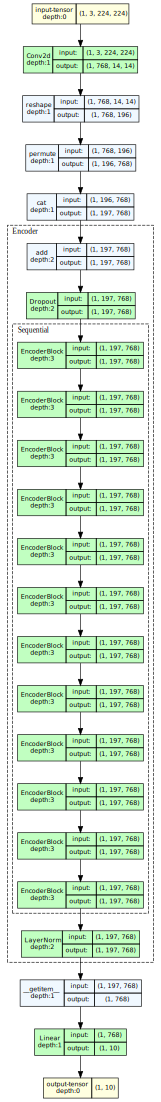

In [27]:
visualize(neural_network, "VIT_B_16 with transform last layer", (1, 3, 224, 224))

In [28]:
def train_and_test_vit(train_dataset, test_dataset, neural_network):
  train_data_loader, test_data_loader = get_loaders(train_dataset, test_dataset)

  neural_network.to(device)

  optimizer = torch.optim.Adam(
    neural_network.heads.parameters(),
    lr = learning_rate)

  print("TRAIN SECTION")
  train(neural_network, train_data_loader, num_epochs, loss_function, optimizer, device)

  print("TEST SECTION")
  return test(neural_network, test_data_loader, device)

In [29]:
_, vit_first_acc = train_and_test_vit(train_dataset_vit, test_dataset_vit, neural_network)

TRAIN SECTION


Epoch[1]: Loss = 0.4992, Train accuracy = 0.8780, Time epoch = 125.2420
Epoch[2]: Loss = 0.2040, Train accuracy = 0.9378, Time epoch = 124.9626
Epoch[3]: Loss = 0.1748, Train accuracy = 0.9453, Time epoch = 125.0616
Epoch[4]: Loss = 0.1585, Train accuracy = 0.9500, Time epoch = 124.9222
Epoch[5]: Loss = 0.1479, Train accuracy = 0.9530, Time epoch = 125.1950
Total time 625.3901407718658
TEST SECTION
Loss = 0.0003, Test accuracy = 0.9462


In [30]:
neural_network = create_vit_second(models.vit_b_16, models.ViT_B_16_Weights.DEFAULT)

Model: VIT_B_16 with transform two last layer
VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-

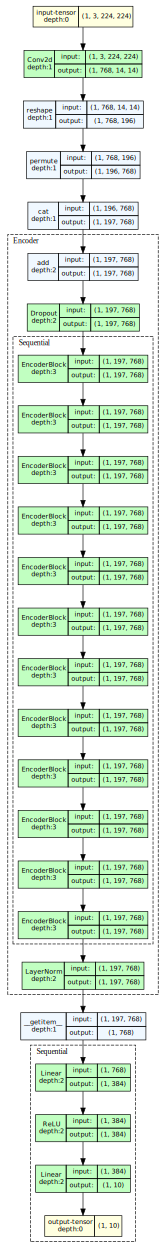

In [31]:
visualize(neural_network, "VIT_B_16 with transform two last layer", (1, 3, 224, 224))

In [32]:
_, vit_second_acc = train_and_test_vit(train_dataset_vit, test_dataset_vit, neural_network)

TRAIN SECTION
Epoch[1]: Loss = 0.2963, Train accuracy = 0.9177, Time epoch = 124.5246
Epoch[2]: Loss = 0.1413, Train accuracy = 0.9520, Time epoch = 124.7931
Epoch[3]: Loss = 0.1191, Train accuracy = 0.9599, Time epoch = 124.8172
Epoch[4]: Loss = 0.1057, Train accuracy = 0.9641, Time epoch = 124.5659
Epoch[5]: Loss = 0.0901, Train accuracy = 0.9696, Time epoch = 124.1648
Total time 622.8725252151489
TEST SECTION
Loss = 0.0003, Test accuracy = 0.9518


## SWIN_T

In [33]:
train_dataset_swin, test_dataset_swin = download_datasets(models.Swin_T_Weights.IMAGENET1K_V1.DEFAULT.transforms())

Files already downloaded and verified
Files already downloaded and verified


In [35]:
neural_network = create_model_first(models.swin_t, models.Swin_T_Weights.IMAGENET1K_V1.DEFAULT)

AttributeError: 'SwinTransformer' object has no attribute 'fc'

In [ ]:
visualize(neural_network, "Swin_T with transform last layer")

In [ ]:
_, swin_first_acc = train_and_test(train_dataset_swin, test_dataset_swin, neural_network)

In [ ]:
neural_network = create_model_second(models.swin_t, models.Swin_T_Weights.IMAGENET1K_V1.DEFAULT)

In [ ]:
visualize(neural_network, "Swin_T with transform two last layer")

In [ ]:
_, swin_second_acc = train_and_test(train_dataset_swin, test_dataset_swin, neural_network)

## 5. Гистограмма

In [ ]:
import seaborn

for_gist = {
    "ResNet152\none": resnet_first_acc.item(),
    "ResNet152\ntwo": resnet_second_acc.item(),
    "GoogLeNet\none": gnet_first_acc.item(),
    "GoogLeNet\ntwo": gnet_second_acc.item(),
    "Swin_T\none": swin_first_acc.item(),
    "Swin_T\ntwo": swin_second_acc.item(),
    "VIT_B_16\none": vit_first_acc,
    "VIT_B_16\ntwo": vit_second_acc
}

seaborn.set(rc={'figure.figsize': (15, 5)})

ax = seaborn.barplot(x=list(for_gist.keys()), y=list(for_gist.values()))

for i in ax.containers:
    ax.bar_label(i,)